<a href="https://colab.research.google.com/github/yma24ma/stock_price_prediction_model/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Prediction Using NLP**
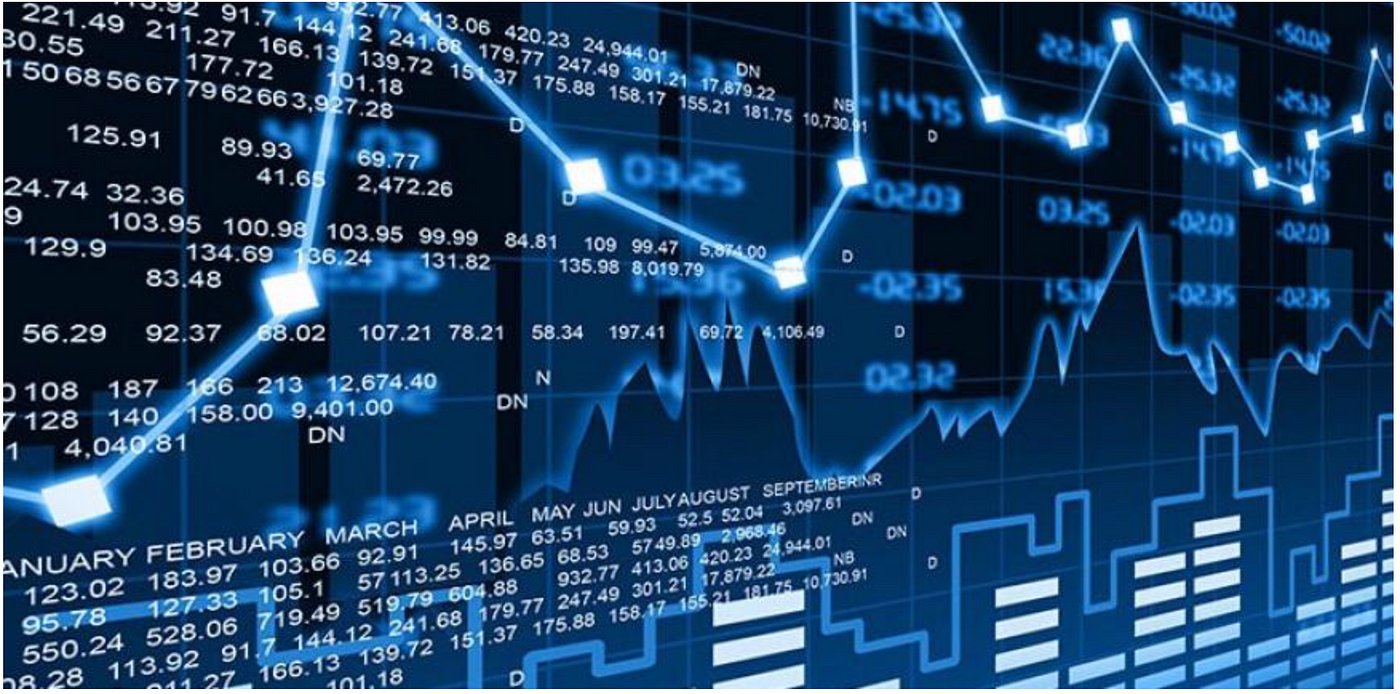
##### Yuki Matsushima

#### Install Required Packages

In [ ]:
!pip install yfinance --upgrade
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

#### Import Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datasets import load_dataset
from datetime import timedelta
import random
from transformers import pipeline

## **Load Financial PhraseBank**
This project uses HuggingFace Datasets to download the Financial PhraseBank, a benchmark dataset for financial sentiment analysis. This is a big collection of financial news sentences, where each sentence has already been labeled by humans as either "positive", "neutral", or "negative" by their tone.

| Score | Label | Example Sentence |
|-------|---------|----------|
| `0` |  Negative | "Profits dropped significantly compared to last quarter." |
| `1` | Neuteral | "Shareholders voted on a new board of directors." |
| `2` | Positive | "The company exceeded its revenue expectations." |

In [ ]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
df_news = pd.DataFrame(dataset["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

#### **Simulate Timeline Data**
Since the Financial PhraseBank dataset does not contain timeline information for each sentiment score, we simulated dates to align each financial sentence with a plausible timeline. We randomly assigned each sentence a date within the 2023 calendar year by selecting an integer between 0 and 364 and adding it to January 1st, 2023. This allows to merge sentiment data with real historical stock prices.

In [ ]:
from datetime import timedelta
start_date = pd.to_datetime("2023-01-01")
df_news['date'] = [start_date + timedelta(days=random.randint(0, 364)) for _ in range(len(df_news))]

#### **Data Wrangling**
To convert the human-labeled sentiment into a numerical form usable by our model, we mapped the original labels (0 = negative, 1 = neutral, 2 = positive) into sentiment scores of -1, 0, and +1 respectively. This allowed us to compute the average sentiment score for each day, making it possible to quantify the daily fluctuation of financial news in a way that could be merged with numerical stock price data.

In [ ]:
label_map = {0: -1, 1: 0, 2: 1}
df_news["sentiment_score"] = df_news["label"].map(label_map)

df_news.head()

,sentence,label,date,sentiment_score
0,"According to Gran , the company has no plans t...",1,2023-01-24,0
1,"For the last quarter of 2010 , Componenta 's n...",2,2023-10-30,1
2,"In the third quarter of 2010 , net sales incre...",2,2023-04-24,1
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,2023-09-08,1
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,2023-11-20,1


#### **Aggregate Human Sentiment by Date**
After assigning sentiment scores to each sentence, we aggregated them on a daily level by grouping the data by date and computing the mean sentiment score for each day. This step produced a single daily sentiment value that reflects the average tone of all financial news for that specific day, forming a time series of sentiment that could later be aligned with daily stock prices.

In [ ]:
daily_sentiments = df_news.groupby("date").agg({"sentiment_score": 'mean'}).reset_index()

daily_sentiments.head()

,date,sentiment_score
0,2023-01-01,0.000000
1,2023-01-02,0.250000
2,2023-01-03,-0.125000
3,2023-01-04,-0.333333
4,2023-01-05,0.500000


## **Apply FinBERT**
In addition to human-labeled sentiment, we incorporated FinBERT, a transformer-based language model specialized for financial sentiment analysis. Each sentence from the Financial PhraseBank was passed through FinBERT algorithm to classify its sentiment as positive, neutral, or negative. We then mapped these categories to numerical scores (`+1`, `0`, `-1` respectively) and computed the daily average FinBERT sentiment score, allowing us to compare and potentially combine both human and machine-generated sentiment scores as a predictor for our model.

In [ ]:
finbert = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")


def analyze_sentiment(text):
  result = finbert(text)[0]['label']
  return {"Positive": 1, "Neutral": 0, "Negative": -1}.get(result, 0)

df_news["finbert_score"] = df_news["sentence"].apply(analyze_sentiment)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


#### **Aggregate FinBERT Sentiment by Date**
Same as human sentiments, after calculating FinBERT sentiment scores for each financial sentence, we aggregated these values at the daily level by computing the mean FinBERT sentiment for each simulated date. This process mirrors the aggregation of human-labeled sentiment and enables a direct comparison between human and machine-derived sentiment time series.

In [ ]:
daily_finbert = df_news.groupby('date')['finbert_score'].mean().reset_index()
daily_finbert.columns = ['date', 'finbert_sentiment_score']

## **Download MSFT Stock Data**
I used the `yfinance` library to download historical daily stock prices for Microsoft (MSFT) covering the full year of 2023. From this dataset, we retained only the closing prices, as they are widely used for end-of-day valuation and modeling. The data was then preprocessed by resetting the index to ensure the `Date` column was in a usable format for merging with sentiment data.

In [ ]:
stock_data = yf.download("MSFT", start="2023-01-01", end="2023-12-31")

if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = [' '.join(col).strip() for col in stock_data.columns.values]


stock_data = stock_data[['Close MSFT']]  # Only use 'Close' price
stock_data = stock_data.reset_index()  # Make 'Date' a column

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## **Merge Sentiment Scores with Stock Data**
I merged the sentiment time series with Microsoft’s stock data using the date as the key. Missing sentiment values were assumed to be neutral and filled with zero. I also created a lagged variable representing the previous day’s closing price, as this is a strong predictor of future prices. Then, I merged in the FinBERT-based sentiment scores in the same manner. This gave me a unified dataset where each row represented a trading day, with associated features for historical price, human sentiment, and FinBERT sentiment.

In [ ]:
# Merge with sentiment
daily_sentiments['date'] = pd.to_datetime(daily_sentiments['date'])  # Ensure datetime format
merged = pd.merge(stock_data, daily_sentiments, left_on='Date', right_on='date', how='left')

merged['label'] = merged['sentiment_score'].fillna(0)
merged['prev_close'] = merged['Close MSFT'].shift(1)
merged = merged.dropna()

# Merge with FinBERT sentiment
merged = pd.merge(merged, daily_finbert, left_on='Date', right_on='date', how='left')
merged['finbert_sentiment_score'] = merged['finbert_sentiment_score'].fillna(0)

merged.head()

,Date,Close MSFT,date_x,sentiment_score,label,prev_close,date_y,finbert_sentiment_score
0,2023-01-04,224.949860,2023-01-04,-0.333333,-0.333333,235.240021,2023-01-04,-0.222222
1,2023-01-05,218.282867,2023-01-05,0.500000,0.500000,224.949860,2023-01-05,0.333333
2,2023-01-06,220.855408,2023-01-06,0.142857,0.142857,218.282867,2023-01-06,-0.142857
3,2023-01-09,223.005722,2023-01-09,-0.142857,-0.142857,220.855408,2023-01-09,-0.142857
4,2023-01-10,224.704391,2023-01-10,-0.222222,-0.222222,223.005722,2023-01-10,-0.222222


## **Modeling**

### **Data Preprocessing**
To prepare the data for modeling, we selected three key features: the average human-labeled sentiment score, the average FinBERT sentiment score, and the previous day’s closing price. These were used as predictors. The target variable was the actual Microsoft closing stock price. To simulate a real-time prediction setting, we used a chronological 80/20 split, where the model is trained on the first 80% of the data and tested on the remaining 20%.

In [ ]:
X = merged[['sentiment_score', 'prev_close', 'finbert_sentiment_score']]
# X = merged[['sentiment_score', 'prev_close']]
y = merged['Close MSFT']

split_index = int(0.8 * len(merged))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

### **Train Linear Regression Model**
I trained a linear regression model using average human-labeled sentiment score, FinBERT sentiment score, and the previous day’s stock prices as the predictor. The model was trained using the training set by using the `LinearRegression()` function from scikit-learn, allowing it to learn how these features relate to Microsoft’s closing price.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### **Make Predictions**
Using the trained model, I generated stock price predictions on the test dataset. This dataset contained new observations with sentiment scores and the previous day’s price, simulating a real-world scenario where we forecast stock prices based on incoming news and historical performance.

In [24]:
predictions = model.predict(X_test)

### **Plot Actual vs Predicted Stock Prices**
I visualized the model’s performance by plotting the actual and predicted stock prices over time. By looking at the visualization, the predicted prices closely followed the actual trend, indicating that the model was effective at capturing stock price movements based on sentiment and past performance.



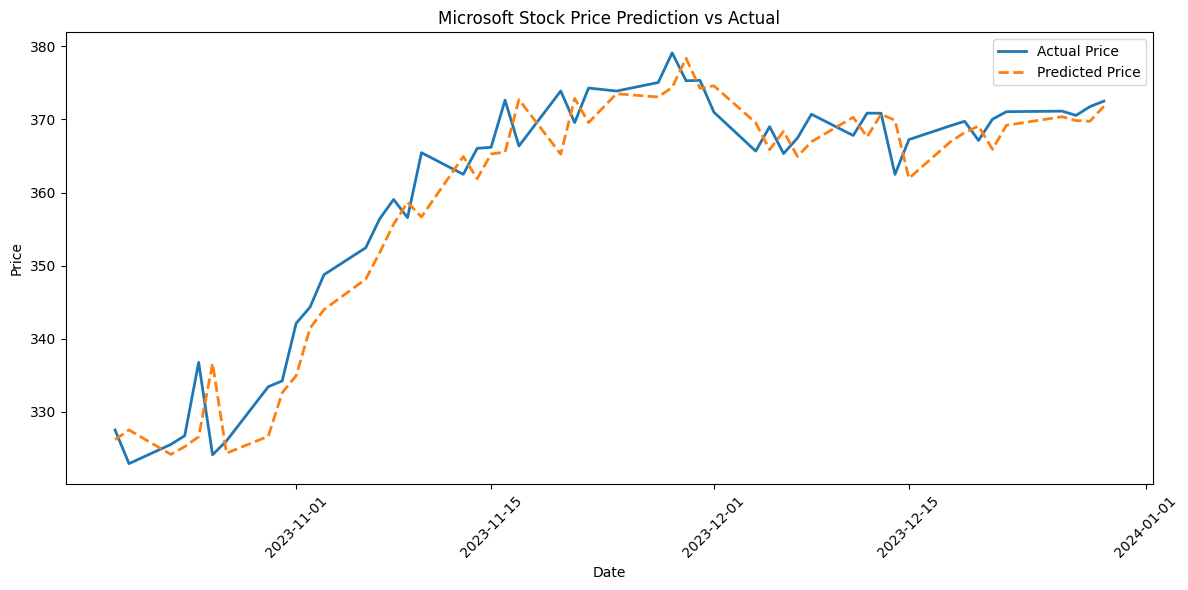

In [ ]:
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(merged['Date'][split_index:], y_test.values, label='Actual Price', linewidth=2)

# Plot predicted prices
plt.plot(merged['Date'][split_index:], predictions, label='Predicted Price', linestyle='--', linewidth=2)


plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Microsoft Stock Price Prediction vs Actual')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## **Model Evaluation**
We evaluated the model’s predictions using three metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). The MAE and RMSE captured the average size of the prediction errors, while the R² score indicated how much of the variation in the actual stock prices are explained by the model.

In [ ]:
# Computing the accuracy of the model

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE:  3.71
MSE:  20.98
RMSE: 4.58
R² Score: 0.9232


The model achieved a MAE of 3.71 and a RMSE of 4.58, indicating that its predictions were typically within \$3 - \$4 of the actual closing price. Moreover, an R² score of 0.9232 suggests that the model explains over 92% of the variation in Microsoft’s stock price. These results indicate a strong predictive performance given the simplicity of the linear regression model and the inherent unpredictability of stock markets.

### **Model Limitations and Further Research**
While the model demonstrated strong predictive performance, the model could be improved by incorporating additional features such as trading volume, technical indicators, or macroeconomic data. Furthermore, this project was based on the assumption of a straight linear relationship between the predictors and the response. Thus, a more sophisticated models like Random Forests or LSTMs could capture nonlinear and sequential patterns more effectively than linear regression.

Future research could explore real-time sentiment analysis using news or social media data, multimodal models that combine technical and fundamental signals, or even causal inference approaches to better understand the relationship between sentiment and stock price movement.